In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.3/39.3 MB 40.3 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mbkinaci/fruit-images-for-object-detection")

print("Path to dataset files:", path)

100%|██████████| 28.4M/28.4M [00:00<00:00, 150MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/mbkinaci/fruit-images-for-object-detection/versions/1


In [5]:
# Set train and test source paths
# dataset_dir = "/kaggle/input/fruit-images-for-object-detection"
dataset_dir = "/root/.cache/kagglehub/datasets/mbkinaci/fruit-images-for-object-detection/versions/1"
train_dir = os.path.join(dataset_dir,"train_zip/train")
test_dir = os.path.join(dataset_dir,"test_zip/test")

In [6]:
# Define destination directories for YOLOv8
dest_dataset_dir = "dataset"
images_dir = os.path.join(dest_dataset_dir,"images")
labels_dir = os.path.join(dest_dataset_dir,"labels")

In [7]:
# Class mapping
class_mapping = {"apple": 0, "banana": 1, "orange": 2}

Draw bounding box on fruit sample

In [8]:
import cv2
from xml.etree import ElementTree as ET

def draw_bounding_box(image_file):
    image = cv2.imread(os.path.join(train_dir,image_file))

    tree = ET.parse(os.path.join(train_dir,str(os.path.splitext(image_file)[0]) + ".xml"))
    root = tree.getroot()

    for obj in root.findall('object'):
        class_name = str(obj.find('name').text) # Fetch the class name
        bbox = obj.find('bndbox')

        # Extract the bounding box labels
        x_min, x_max, y_min, y_max = (
            int(bbox.find('xmin').text),
            int(bbox.find('xmax').text),
            int(bbox.find('ymin').text),
            int(bbox.find('ymax').text)
        )

        # draw a rectangle
        cv2.rectangle(image,(x_min,y_min),(x_max,y_max),color=(0,255,0),thickness=2)

        # add text above the bounding box
        cv2.putText(img=image,text=class_name,org=(x_min,y_min-10),fontFace=cv2.FONT_HERSHEY_SIMPLEX,fontScale=0.9,color=(0,255,0),thickness=2)

    plt.imshow(image)
    plt.axis('off')
    plt.show();

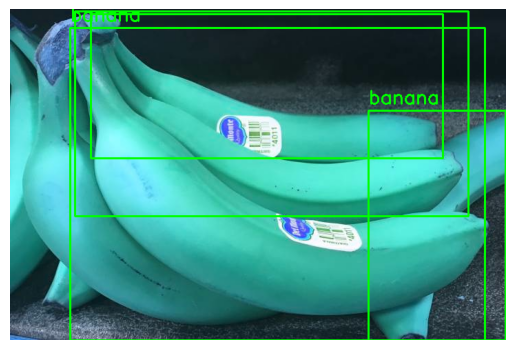

In [9]:
draw_bounding_box("banana_10.jpg")

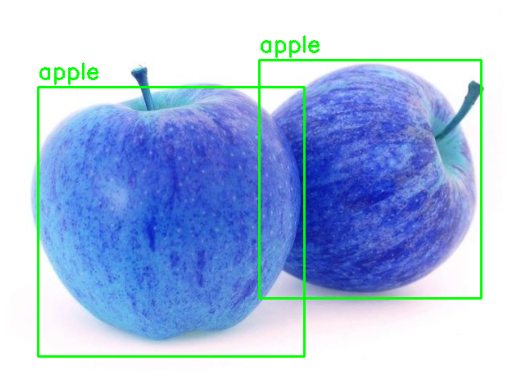

In [10]:
draw_bounding_box("apple_45.jpg")

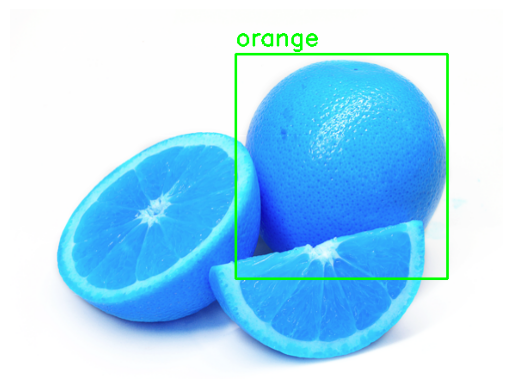

In [11]:
draw_bounding_box("orange_50.jpg")

Convert Image to YOLO format

In [12]:
# Create destination directories
for split in ['train','val']:
    os.makedirs(os.path.join(images_dir,split),exist_ok=True)
    os.makedirs(os.path.join(labels_dir,split),exist_ok=True)

In [13]:
def convert_pvoc_to_yolo(width, height, bbox_labels):
    x_min, y_min, x_max, y_max = bbox_labels

    x_center = (x_min + x_max) / 2 / (width+1e-6)
    y_center = (y_min + y_max) / 2 / (height+1e-6)
    box_width = (x_max - x_min) / (width+1e-6)
    box_height = (y_max - y_min) / (height+1e-6)

    return (x_center, y_center, box_width, box_height)

In [14]:
# Parse .xml files and convert it into YOLO format
import shutil, random
def parse_xml_to_yolo(src_dir,split):
    image_files = [file for file in os.listdir(src_dir) if file.endswith('.jpg')]

    for image_file in image_files:
        # Define source and destination paths for images and labels
        src_image_path = os.path.join(src_dir,image_file)
        src_label_path = os.path.join(src_dir,os.path.splitext(image_file)[0] + ".xml")
        dest_image_path = os.path.join(images_dir,split,image_file)
        dest_label_path = os.path.join(labels_dir,split,os.path.splitext(image_file)[0] + ".txt")

        # Copy images from source to destination directory
        shutil.copy2(src_image_path,dest_image_path)

        # Parse XML
        tree = ET.parse(src_label_path)
        root = tree.getroot()

        size = root.find('size')
        width = int(size.find('width').text)
        height = int(size.find('height').text)
        depth = int(size.find('depth').text)

        with open(dest_label_path,'w') as f:
            for obj in root.findall('object'):
                name_tag = obj.find('name')

                if name_tag is None: # Skip if name tag returns None
                    continue

                class_label = name_tag.text
                if class_label not in class_mapping:
                    continue

                class_id = class_mapping.get(class_label)

                bbox_labels = obj.find('bndbox')
                if bbox_labels is None: # Skip if bbox labels are None
                    continue

                bbox = (
                    float(bbox_labels.find('xmin').text),
                    float(bbox_labels.find('ymin').text),
                    float(bbox_labels.find('xmax').text),
                    float(bbox_labels.find('ymax').text)
                )
                yolo_box = convert_pvoc_to_yolo(width,height,bbox)
                f.write(f"{class_id} {' '.join(map(str,yolo_box))}\n")

In [15]:
# Convert both train and test data to YOLO format
parse_xml_to_yolo(train_dir,'train')
parse_xml_to_yolo(test_dir,'val')

In [16]:
# Define YAML content
yaml_content = """
    train: dataset/images/train
    val: dataset/images/val

    nc: 3
    names: ['apple','banana','orange']
"""

# Create a data.yaml file
with open("data.yaml","w") as f:
    f.write(yaml_content)

Model Training an d Evaluation

In [17]:
# Create a YOLOv8 model
from ultralytics import YOLO
model = YOLO('yolov8n.yaml')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [19]:
model.train(
    data='data.yaml',
    epochs=100,
    batch=16,  # Smaller batch size to prevent memory issues
    imgsz=512, # Reduced image size for faster processing
    workers=4  # Increased workers for faster data loading
)

Ultralytics 8.3.191 🚀 Python-3.12.11 torch-2.8.0+cpu CPU (AMD EPYC 7B13)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=False, proj

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f840ceb6240>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

Model Inference

In [20]:
inv_class_mapping = {v: k for k, v in class_mapping.items()}

In [21]:
def detect_fruits(model,test_image_path):
    results = model(test_image_path)
    image = cv2.imread(test_image_path)

    for result in results:
        for detection in result.boxes:
            x_min, y_min, x_max, y_max = detection.xyxy[0]
            x_min, y_min, x_max, y_max = int(x_min), int(y_min), int(x_max), int(y_max)
            confidence = detection.conf[0]
            class_id = int(detection.cls[0])
            class_name = inv_class_mapping.get(class_id)

            label = f"{class_name}: {confidence:.2f}"

            # Draw bounding box
            cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color=(0, 255, 0), thickness=2)

            (text_width, text_height), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_DUPLEX, fontScale=0.8, thickness=2)
            cv2.rectangle(image, (x_min, y_min - text_height - 10), (x_min + text_width, y_min), (0, 255, 0), -1)

            # Draw text
            cv2.putText(
                img=image,
                text=label,
                org=(x_min, y_min - 5),
                fontFace=cv2.FONT_HERSHEY_DUPLEX,
                fontScale=0.8,
                color=(0, 0, 0),  # Black text for contrast on green
                thickness=2,
                lineType=cv2.LINE_AA
            )

    # Convert the image to RGB format for matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.axis('off')
    plt.imshow(image_rgb)
    plt.show()


image 1/1 /root/.cache/kagglehub/datasets/mbkinaci/fruit-images-for-object-detection/versions/1/test_zip/test/mixed_22.jpg: 512x512 3 apples, 1 banana, 1 orange, 47.6ms
Speed: 1.6ms preprocess, 47.6ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 512)


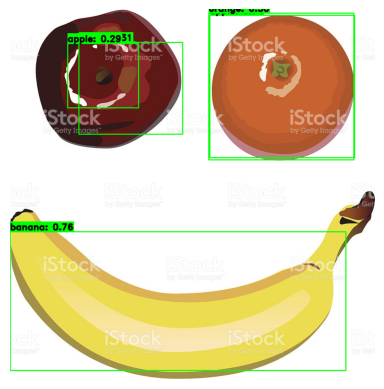

In [23]:
test_image_path = "/root/.cache/kagglehub/datasets/mbkinaci/fruit-images-for-object-detection/versions/1/test_zip/test/mixed_22.jpg"
detect_fruits(model,test_image_path)


image 1/1 /root/.cache/kagglehub/datasets/mbkinaci/fruit-images-for-object-detection/versions/1/test_zip/test/mixed_25.jpg: 384x512 2 apples, 1 orange, 47.0ms
Speed: 1.1ms preprocess, 47.0ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 512)


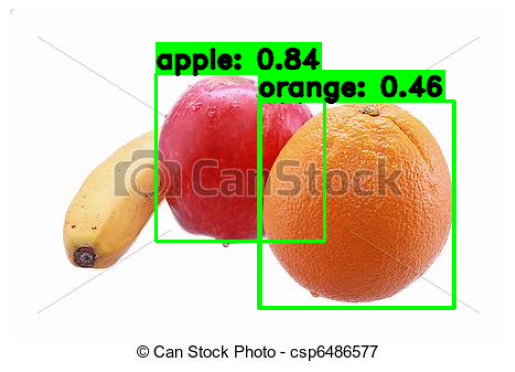

In [25]:
test_image_path = "/root/.cache/kagglehub/datasets/mbkinaci/fruit-images-for-object-detection/versions/1/test_zip/test/mixed_25.jpg"
detect_fruits(model,test_image_path)


image 1/1 /root/.cache/kagglehub/datasets/mbkinaci/fruit-images-for-object-detection/versions/1/test_zip/test/orange_92.jpg: 352x512 1 orange, 44.9ms
Speed: 1.0ms preprocess, 44.9ms inference, 0.6ms postprocess per image at shape (1, 3, 352, 512)


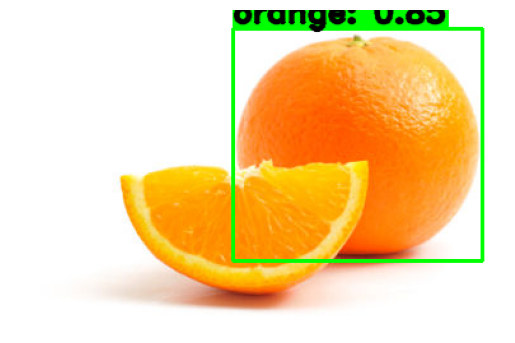

In [26]:
test_image_path = "/root/.cache/kagglehub/datasets/mbkinaci/fruit-images-for-object-detection/versions/1/test_zip/test/orange_92.jpg"
detect_fruits(model,test_image_path)


image 1/1 /root/.cache/kagglehub/datasets/mbkinaci/fruit-images-for-object-detection/versions/1/test_zip/test/apple_93.jpg: 352x512 1 apple, 31.2ms
Speed: 1.1ms preprocess, 31.2ms inference, 0.6ms postprocess per image at shape (1, 3, 352, 512)


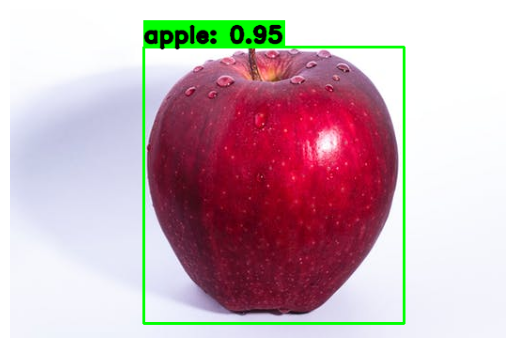

In [27]:
test_image_path = "/root/.cache/kagglehub/datasets/mbkinaci/fruit-images-for-object-detection/versions/1/test_zip/test/apple_93.jpg"
detect_fruits(model,test_image_path)